**<font size = 5 > 0. SETUP LIBRARIES AND FUNCTIONS** </font>

In [1]:
import time
from pathlib import Path
from ruamel.yaml import YAML
import re
import numpy as np 
np.random.seed(10)
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gzip
import nltk
from nltk import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import Input, Flatten, Activation, Concatenate
from keras.layers import Dense, GRU, Bidirectional,Conv1D
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, MaxPool1D
from keras.layers import Dropout,SpatialDropout1D, Embedding
from tensorflow.keras.regularizers import l1_l2
from keras.models import Model, Sequential
from keras.callbacks import Callback
import warnings
warnings.filterwarnings("ignore")
stop_words = set(stopwords.words("english"))
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

#####--- 0.1 Define some functions used later in the program

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

def load_glove_vector(file):
    """load GloVe Vector"""
    f = open(file,'r')
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector
    f.close()
    
def remove_urls(text):
    text = re.sub(r"http\S+", "", text)
    return text

def remove_contraction(text):
    """remove contractions"""
    for word in text.split():
        if word in config["contractions"]:
            text = text.replace(word, config["contractions"][word])
    return text

def remove_emoji(text):
    """remove emojis"""
    text = re.sub(r"(\<u+\S*>)", "", text)
    return text

def remove_special_chars(text):
    return re.sub('[^a-zA-Z]', ' ', text)
    
def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())

def lemmatize_all(sentence):
    """lemmatize text"""
    wnl = WordNetLemmatizer()
    for word, tag in pos_tag(word_tokenize(sentence)):
        if tag.startswith("NN"):
            yield wnl.lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            yield wnl.lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            yield wnl.lemmatize(word, pos='a')
        elif tag.startswith('R'):
            yield wnl.lemmatize(word, pos='r')
            
        else:
            yield word    

start_time = time.time()
print("--- Executed in %s seconds ---" % (time.time() - start_time))



Using TensorFlow backend.


--- Executed in 3.2901763916015625e-05 seconds ---


[nltk_data] Downloading package punkt to /Users/ivanmera/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ivanmera/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ivanmera/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ivanmera/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**<font size = 5 > 1. IMPORT DATA AND CONFIG_FILE** </font>

In [2]:
#######################--- 1. READ CONFIG_FILE AND LOAD ALL FILES ---#######################
#####--- 1.0 Read Config_File
path  = Path('/Users/ivanmera/Documents/TMS/PROJECT')
path_input = path.joinpath("input")
yaml        = YAML(typ='safe')
config      = yaml.load(path.joinpath("Config_File.yml"))

#####--- 1.1 Load both reviews and GloVe vector
print("--- Importing all inputs ---")
df_1 = getDF(path_input.joinpath(config["df_1"]))
print("--- Imported df_1 reviews in %s seconds ---" % (time.time() - start_time))
df_2 = getDF(path_input.joinpath(config["df_2"]))
print("--- Imported df_2 reviews in %s seconds ---" % (time.time() - start_time))
df_3 = getDF(path_input.joinpath(config["df_3"]))
print("--- Imported df_3 reviews in %s seconds ---" % (time.time() - start_time))
df_4 = getDF(path_input.joinpath(config["df_4"]))
print("--- Imported df_4 reviews in %s seconds ---" % (time.time() - start_time))
embeddings_dict = {}
load_glove_vector(path_input.joinpath(config['glove_vec']))
print("--- Imported GloVe vector in %s seconds ---" % (time.time() - start_time))

print("--- Imported all dataframes in %s seconds ---" % (time.time() - start_time))

--- Importing all inputs ---
--- Imported df_1 reviews in 161.96719098091125 seconds ---
--- Imported df_2 reviews in 179.4524850845337 seconds ---
--- Imported df_3 reviews in 243.55396699905396 seconds ---
--- Imported df_4 reviews in 260.0641767978668 seconds ---
--- Imported GloVe vector in 284.6937348842621 seconds ---
--- Imported all dataframes in 284.6955759525299 seconds ---


In [3]:
print(len(df_1),len(df_2),len(df_3),len(df_4))

1758333 574628 1512530 602777


**<font size = 5 > 2. EDA AND FEATURE ENGINEERING** </font>

In [3]:
#####--- 2.0 Computer percentage of missing data
print("Missing df_1")
print(df_1.isna().sum()/len(df_1))
print("Missing df_2")
print(df_2.isna().sum()/len(df_2))
print("Missing df_3")
print(df_3.isna().sum()/len(df_3))
print("Missing df_4")
print(df_4.isna().sum()/len(df_4))

#####--- 2.1 Delete osservations where reviewText is null
df_1.dropna(subset=["reviewText"], inplace = True)
df_1.reset_index(drop = True, inplace = True)
df_2.dropna(subset=["reviewText"], inplace = True)
df_2.reset_index(drop = True, inplace = True)
df_3.dropna(subset=["reviewText"], inplace = True)
df_3.reset_index(drop = True, inplace = True)
df_4.dropna(subset=["reviewText"], inplace = True)
df_4.reset_index(drop = True, inplace = True)

#####--- 2.2 Compute the number of reviews per product
n_review_1 = df_1.groupby('asin')['reviewerID'].count().sort_values(ascending=False)
n_review_2 = df_2.groupby('asin')['reviewerID'].count().sort_values(ascending=False)
n_review_3 = df_3.groupby('asin')['reviewerID'].count().sort_values(ascending=False)
n_review_4 = df_4.groupby('asin')['reviewerID'].count().sort_values(ascending=False)
n_review = pd.concat([n_review_1,n_review_2,n_review_3,n_review_4])

#####--- 2.3 Create target column for each df
df_1["target"] = 0
df_2["target"] = 1
df_3["target"] = 2
df_4["target"] = 3

#####--- 2.4 Merge all df
df_all = pd.concat([df_1,df_2,df_3,df_4])

print(df_all.shape)

Missing df_1
reviewText    0.00056
asin          0.00000
reviewerID    0.00000
dtype: float64
Missing df_2
reviewText    0.000696
asin          0.000000
reviewerID    0.000000
dtype: float64
Missing df_3
reviewText    0.000565
asin          0.000000
reviewerID    0.000000
dtype: float64
Missing df_4
reviewText    0.000538
asin          0.000000
reviewerID    0.000000
dtype: float64
(4445705, 4)


**<font size = 5 > 3. TEXT PREPROCESSING** </font>

In [6]:
#####--- 3.0 Normalize and remove noise df_all data
df_all["reviewText"] = df_all["reviewText"].str.lower()
df_all["reviewText"] = df_all["reviewText"].apply(remove_urls)
df_all["reviewText"] = df_all["reviewText"].apply(remove_contraction)
df_all["reviewText"] = df_all["reviewText"].apply(remove_emoji)
df_all["reviewText"] = df_all["reviewText"].apply(remove_special_chars)
df_all["reviewText"] = df_all["reviewText"].apply(remove_whitespace)
print("--- Preproccess df_all data in %s seconds ---" % (time.time() - start_time))

#####--- 3.1 Remove stopwords
df_all['reviewText'] = df_all['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
print("--- Removed stop words in %s seconds ---" % (time.time() - start_time))

#####--- 3.2 Get only one review per product
df_all["review_length"] = df_all["reviewText"].apply(lambda x: len(x))
df_all = df_all.sort_values('review_length', ascending = False).groupby('asin').first()

#####--- 3.3 Reset index and get only two vars
df_all.reset_index(inplace = True)
df_all = df_all[["reviewText","target"]]
df_all.dropna(subset=["reviewText"], inplace = True)
df_all.reset_index(drop = True, inplace = True)

#####--- 3.4 Lemmatization
df_all_lemma = []
for i in range(0,len(df_all)):
    df_all_lemma.append(" ".join(lemmatize_all(str(df_all["reviewText"].values[i]))))
print("--- Lemmatized df in %s seconds ---" % (time.time() - start_time))

--- Preproccess df_all data in 456.1690001487732 seconds ---
--- Removed stop words in 492.7654731273651 seconds ---


**<font size = 5 > 4. TEXT REPRESENTATION** </font>

In [ ]:
##################--- TF-IDF REPRESENTATION ---##################
#####--- 4.0 TF-IDF representation
# Tranform lemma list in dataframe and concat target values
df_lemma= pd.DataFrame(df_all_lemma, columns=["reviewText"])
df_lemma["target"] = df_all["target"]

# Create corpus and target variables
corpus = df_lemma['reviewText']
target = df_lemma["target"]

# Create TF-IDF
tfidf = TfidfVectorizer(max_features=config["max_features_tf"], analyzer='word',ngram_range=(1,1))
train_vect = tfidf.fit_transform(corpus)


#####--- 4.1 Split data train/test for both TF-IDF and EMBEDDINGS
x_train_tf, x_test_tf, y_train_tf, y_test_tf = train_test_split(train_vect, target, test_size = 0.2, random_state = 123)
x_train_emb, x_test_emb, y_train_emb, y_test_emb = train_test_split(corpus, target, test_size = 0.2, random_state = 123)

##################--- EMBEDDING REPRESENTATION---##################
#####--- 4.2 Tokenize and create pad sequence
print("Started plain tokenization")
tokenizer = text.Tokenizer(num_words = config["max_features"])
tokenizer.fit_on_texts(list(x_train_emb)) # Fit in X_train if none of above technique was done
X_train = tokenizer.texts_to_sequences(x_train_emb)
X_test = tokenizer.texts_to_sequences(x_test_emb)
x_train = sequence.pad_sequences(X_train, maxlen = config["maxlen"])
x_test = sequence.pad_sequences(X_test, maxlen = config["maxlen"])
print("Finished plain tokenization")

#####--- 4.3 Create embedding matrix
# 4.3.0 Compute mean and std of embeddings
all_embs = np.stack(embeddings_dict.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()

# 4.3.1 Fill embedding matrix with Glove values based on word_index
word_index = tokenizer.word_index
nb_words = min(config["max_features"], len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, config["embed_size"]))
for word, i in word_index.items():
    if i >= config["max_features"]: 
        continue
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

In [104]:
print(len(word_index))
#108877

108877


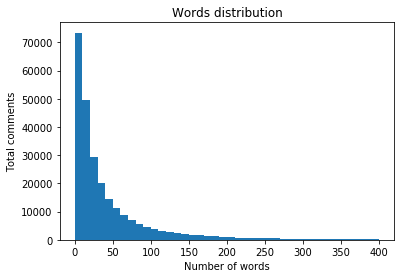

In [42]:
Num_words = [len(x) for x in X_train]
plt.hist(Num_words,bins = np.arange(0,410,10))
plt.title('Words distribution')
plt.ylabel('Total comments')
plt.xlabel('Number of words')
plt.show()

**<font size = 5 > 5. MODELING TF-IDF** </font>

In [79]:
#####--- 5.0 Split data train/validation
X_tra_tf, X_val_tf, y_tra_tf, y_val_tf = train_test_split(x_train_tf, y_train_tf, test_size=0.1, random_state=456)

model = Sequential([
    Dense(2048, input_dim = config["max_features_tf"]),
    Activation('elu'),
    Dense(2048),
    Activation('elu'),
    Dense(1024),
    Activation('elu'),
    Dense(512),
    Activation('elu'),
    Dense(4),
    Activation('softmax'),
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [80]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 2048)              20482048  
_________________________________________________________________
activation_51 (Activation)   (None, 2048)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
activation_52 (Activation)   (None, 2048)              0         
_________________________________________________________________
dense_53 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
activation_53 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 512)             

In [81]:
hist_tf = model.fit(X_tra_tf, y_tra_tf, batch_size=32, epochs=4, validation_data=(X_val_tf, y_val_tf))

Train on 230418 samples, validate on 25603 samples
Epoch 1/4
230418/230418 [==============================] - 2681s 12ms/step - loss: 0.4255 - accuracy: 0.8484 - val_loss: 0.3762 - val_accuracy: 0.8632
Epoch 2/4
230418/230418 [==============================] - 2637s 11ms/step - loss: 0.3759 - accuracy: 0.8674 - val_loss: 0.3686 - val_accuracy: 0.8689
Epoch 3/4
230418/230418 [==============================] - 2666s 12ms/step - loss: 0.3493 - accuracy: 0.8732 - val_loss: 0.3837 - val_accuracy: 0.8597
Epoch 4/4
230418/230418 [==============================] - 2758s 12ms/step - loss: 0.3304 - accuracy: 0.8798 - val_loss: 0.3873 - val_accuracy: 0.8659


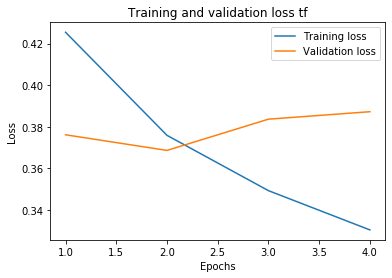

In [86]:
#####--- 5.2 Plot Loss graph
loss_tf = hist_tf.history['loss']
val_loss_tf = hist_tf.history['val_loss']
epochs_tf = range(1, len(loss_tf)+1)
plt.plot(epochs_tf, loss_tf, label='Training loss')
plt.plot(epochs_tf, val_loss_tf, label='Validation loss')
plt.title('Training and validation loss tf')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

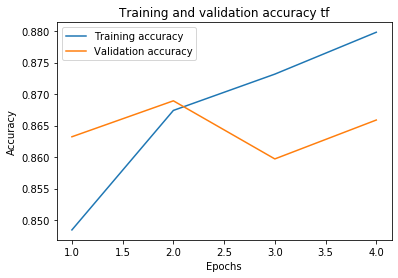

In [87]:
#####--- 5.3 Plot Accuracy graph
accuracy_tf = hist_tf.history['accuracy']
val_accuracy_tf = hist_tf.history['val_accuracy']
plt.plot(epochs_tf, accuracy_tf, label='Training accuracy')
plt.plot(epochs_tf, val_accuracy_tf, label='Validation accuracy')
plt.title('Training and validation accuracy tf')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [ ]:
#####--- 5.4 Calculate RocAuc, loss and accuracy
res_tf = model.evaluate(x_test_tf,y_test_tf)

In [24]:
res_tf

[0.37842917988043107, 0.8685435652732849]

**<font size = 5 > 6. MODELING GLOVE EMBEDDINGS** </font>

In [93]:
#####--- 6.0 Split data train/validation
X_tra_emb, X_val_emb, y_tra_emb, y_val_emb = train_test_split(x_train, y_train_emb, test_size=0.1, random_state=456)

#####--- 6.1 Create GRU + CNN model architecture
inp = Input(shape=(config["maxlen"],))
x = Embedding(config["max_features"], config["embed_size"], weights=[embedding_matrix], trainable = False)(inp)
x = Bidirectional(GRU(80, return_sequences=True))(x)
x = Conv1D(64, kernel_size=3, kernel_initializer='normal', activation='elu')(x)
x = Dropout(0.2)(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = Concatenate()([avg_pool, max_pool])
#x = Dropout(0.2)(x)
out = Dense(4, activation='softmax')(x)

model = Model(inputs = inp, outputs = out)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [94]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 200)     20000000    input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 200, 160)     134880      embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 198, 64)      30784       bidirectional_2[0][0]            
____________________________________________________________________________________________

In [95]:
#####--- 6.1 Fit model
hist_emb = model.fit(X_tra_emb, y_tra_emb, batch_size=32, epochs=4, validation_data=(X_val_emb, y_val_emb))

Train on 230418 samples, validate on 25603 samples
Epoch 1/4
230418/230418 [==============================] - 1929s 8ms/step - loss: 0.4273 - accuracy: 0.8447 - val_loss: 0.3894 - val_accuracy: 0.8606
Epoch 2/4
230418/230418 [==============================] - 2071s 9ms/step - loss: 0.3636 - accuracy: 0.8680 - val_loss: 0.3706 - val_accuracy: 0.8676
Epoch 3/4
230418/230418 [==============================] - 2132s 9ms/step - loss: 0.3367 - accuracy: 0.8771 - val_loss: 0.3679 - val_accuracy: 0.8650
Epoch 4/4
230418/230418 [==============================] - 2417s 10ms/step - loss: 0.3133 - accuracy: 0.8850 - val_loss: 0.3872 - val_accuracy: 0.8595


In [96]:
hist_emb.history

{'accuracy': [0.8447213, 0.8680051, 0.87705386, 0.88498294],
 'loss': [0.42725303109424606,
  0.3636261612754529,
  0.3367467257366284,
  0.3133227775549874],
 'val_accuracy': [0.8605632185935974,
  0.8675936460494995,
  0.8649767637252808,
  0.8595086336135864],
 'val_loss': [0.38941852465479726,
  0.3706264543871123,
  0.3679304585202441,
  0.3871729331433631]}

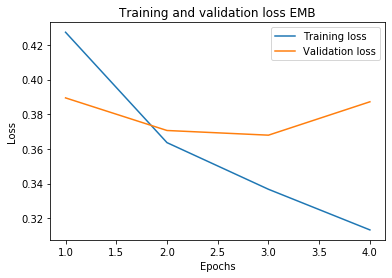

In [97]:
#####--- 6.2 Plot Loss graph
loss_emb = hist_emb.history['loss']
val_loss_emb = hist_emb.history['val_loss']
epochs_emb = range(1, len(loss_emb)+1)
plt.plot(epochs_emb, loss_emb, label='Training loss')
plt.plot(epochs_emb, val_loss_emb, label='Validation loss')
plt.title('Training and validation loss EMB')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

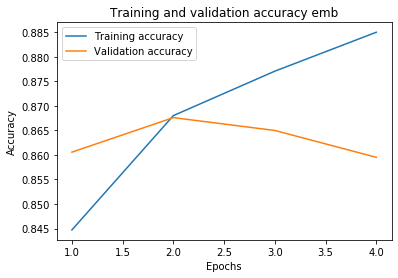

In [98]:
#####--- 6.3 Plot Accuracy graph
accuracy_emb = hist_emb.history['accuracy']
val_accuracy_emb = hist_emb.history['val_accuracy']
plt.plot(epochs_emb, accuracy_emb, label='Training accuracy')
plt.plot(epochs_emb, val_accuracy_emb, label='Validation accuracy')
plt.title('Training and validation accuracy emb')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [103]:
#####--- 6.4 Calculate loss and accuracy
res_emb = model.evaluate(x_test,y_test_emb)
res_emb

64006/64006 [==============================] - 146s 2ms/step


[0.3789918731533403, 0.8621535301208496]